This week in [Udacity's Intro to Self-driving Cars Nanodegree](https://www.udacity.com/course/intro-to-self-driving-cars--nd113), I learned how to do chroma key compositing. I made the process more precise by doing some data analysis using Numpy and Pandas.

I show how the "green screen" effect can work quite well even when the background has highly irregular lighting as long as you process the image as HSV instead of RGB.

First, I display the original images and their dimensions. I'll be overlaying my girlfriend's hand onto wallpaper featuring my comic book studio's logo.

hand shape:  (4032, 3024, 3)


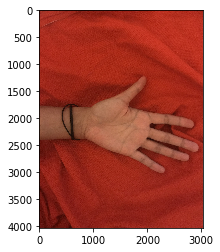

In [164]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

hand = mpimg.imread("hand.jpg")
print("hand shape: ", hand.shape)
plt.imshow(hand)

bg shape:  (4032, 3024, 3)


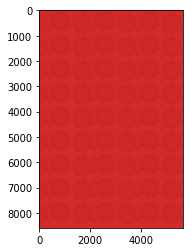

In [165]:
bg = mpimg.imread("qalang_wallpaper.jpg")
print("bg shape: ", hand.shape)
plt.imshow(bg)

Let's crop the background down to the hand pic's size.

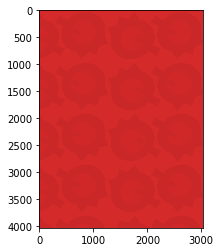

In [166]:
bg_cropped = bg[:len(hand), :len(hand[0]), :]
plt.imshow(bg_cropped)
plt.show()

I use OpenCV to convert the RGB image to HSV, which is a much better format for doing compositing, since it is more [robust to lighting variations than RGB images.](https://en.wikipedia.org/wiki/HSL_and_HSV#Use_in_image_analysis)

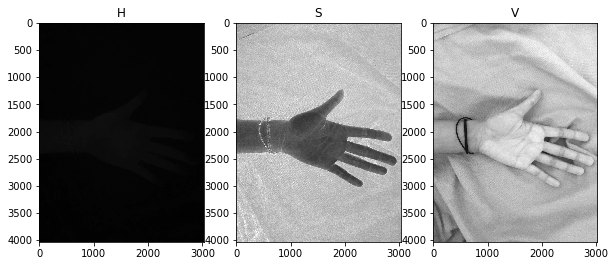

In [167]:
import cv2

hand_hsv = cv2.cvtColor(hand, cv2.COLOR_RGB2HSV)

h = hand_hsv[:, :, 0]
s = hand_hsv[:, :, 1]
v = hand_hsv[:, :, 2]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.set_title("H")
ax1.imshow(h, cmap="gray")
ax2.set_title("S")
ax2.imshow(s, cmap="gray")
ax3.set_title("V")
ax3.imshow(v, cmap="gray")
plt.show()

Eyeballing these charts, saturation looks the most promising, but later we'll see quantitatively that hue is better - the background is all the same color! And you can see that the bracelet saturation is very similar to the background saturation.

So let's use a quantitative approach to separate the hand from the background. When we increase contrast, you can see that in the H, the wrinkles completely disappear from the image.

For contrast, here's what the RGB looks like. 

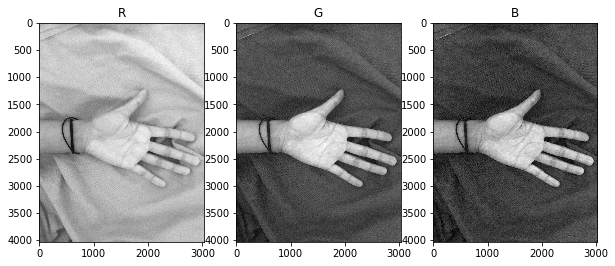

In [168]:
r = hand[:, :, 0]
g = hand[:, :, 1]
b = hand[:, :, 2]

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.set_title("R")
ax1.imshow(r, cmap="gray")
ax2.set_title("G")
ax2.imshow(g, cmap="gray")
ax3.set_title("B")
ax3.imshow(b, cmap="gray")
plt.show()

In RGB land, shadows abound.

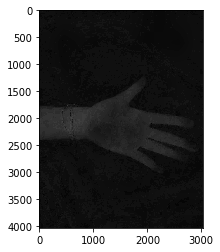

In [169]:
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10,10))
h_clahe = clahe.apply(h)
plt.imshow(h_clahe, cmap="gray")

Let's explore the top and bottom of the image, which clearly have no hand in them.

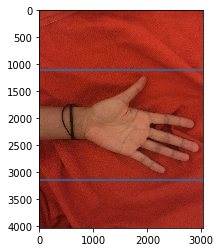

In [170]:
top_crop_y = 1100
bottom_crop_y = 3150

plt.imshow(hand)
plt.axhline(y=top_crop_y)
plt.axhline(y=bottom_crop_y)

Using numpy and pandas, I'll flatten those sections of the images, since I'm only interested in them as a collection of pixels divorced from their exact location.  Then we can see sum summary statistics of the HSV values.

In [171]:
import numpy as np
import pandas as pd

hand_flattened = []

for index in range(3):
    hand_top = np.array(hand_hsv[:top_crop_y, :, index]).flatten()
    hand_bottom = np.array(hand_hsv[bottom_crop_y:, :, index]).flatten()
    top_and_bottom = np.append(hand_top, hand_bottom)
    top_and_bottom_series = pd.Series(top_and_bottom)
    print(top_and_bottom_series.describe())
    hand_flattened.append(top_and_bottom_series)

count    5.993568e+06
mean     2.822141e+00
std      6.830892e-01
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      3.000000e+00
max      1.790000e+02
dtype: float64
count    5.993568e+06
mean     2.121298e+02
std      8.109752e+00
min      1.380000e+02
25%      2.070000e+02
50%      2.120000e+02
75%      2.170000e+02
max      2.550000e+02
dtype: float64
count    5.993568e+06
mean     1.611594e+02
std      2.154652e+01
min      4.800000e+01
25%      1.480000e+02
50%      1.630000e+02
75%      1.750000e+02
max      2.140000e+02
dtype: float64


 We'll use a scatter plot to see how to values are distributed. Hue is definitely the most helpful channel!

''

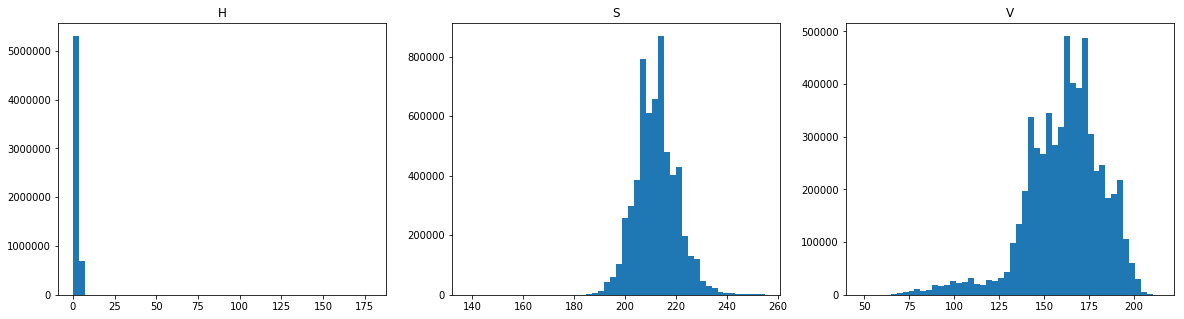

In [172]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
ax1.set_title("H")
ax1.hist(hand_flattened[0], bins=50)
ax2.set_title("S")
ax2.hist(hand_flattened[1], bins=50)
ax3.set_title("V")
ax3.hist(hand_flattened[2], bins=50)
;

Because of the left skew of V, but we can still use it! Now we'll compute high and low ranges for each of the channels, including all values within 5.5 standard deviations of the mean value.

In [173]:
low = []
high = []

def restrict(color_component):
    return np.clip(color_component, 0, 255)

z_value = 5.5

for i in range(3):
    mu = hand_flattened[i].values.mean()
    sigma = hand_flattened[i].values.std()
    deviation = z_value*sigma
    low.append(restrict(mu-deviation))
    high.append(restrict(mu+deviation))

print(low)
print(high)

[0.0, 167.52616408398197, 42.65355286674098]
[6.579130953851298, 255.0, 255.0]


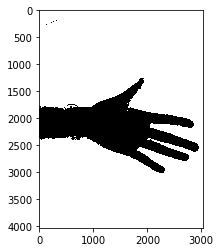

In [174]:
mask_lower = np.array([low[0], low[1], low[2]])
mask_higher = np.array([high[0], high[1], high[2]])

hand_mask = cv2.inRange(hand_hsv, mask_lower, mask_higher)
plt.imshow(hand_mask, cmap="gray")
plt.show()

We'll chop off the parts of the image that we used to isolate the red background.

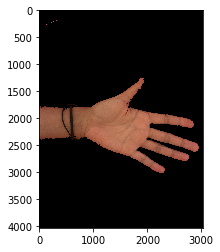

In [175]:
masked_hand = np.copy(hand)
masked_hand[hand_mask != 0] = [0, 0, 0]

plt.imshow(masked_hand)

Let's clean up the gunk in the top left of the image by wiping the top and bottom of the mask.

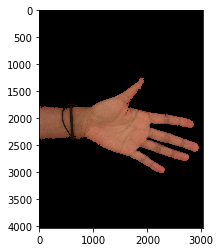

In [176]:
hand_mask[:top_crop_y,:] = [1]
hand_mask[bottom_crop_y:,:] = [1]

masked_hand = np.copy(hand)
masked_hand[hand_mask != 0] = [0, 0, 0]

plt.imshow(masked_hand)
#plt.show()

It's time for the background.

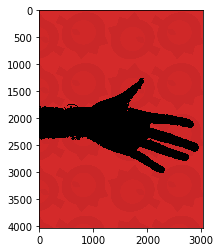

In [177]:
bg_masked = np.copy(bg_cropped)
bg_masked[hand_mask == 0] = [0,0,0]

plt.imshow(bg_masked)
plt.show()

Adding them together...

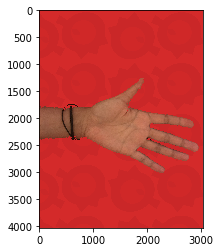

In [178]:
full_picture = bg_masked + masked_hand

plt.imshow(full_picture)

For contrast, let's try the same approach in RGB. Since there's so much variation in the RGB, we're going to have to radically lower the z-value.

In [179]:
rgb_low = []
rgb_high = []

rgb_z_value = 1.5

for i in range(3):
    channel = np.array(hand[:,:,i])
    mu = channel.mean()
    sigma = channel.std()
    deviation = rgb_z_value*sigma
    rgb_low.append(restrict(mu-deviation))
    rgb_high.append(restrict(mu+deviation))

print(rgb_low)
print(rgb_high)

[119.34782725422687, 11.372475414659547, 3.5965680695912283]
[192.2016281278488, 85.82654239655444, 63.865580148106346]


These values don't look promising!

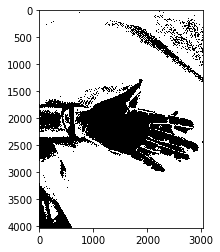

In [180]:
rgb_mask_lower = np.array([rgb_low[0], rgb_low[1], rgb_low[2]])
rgb_mask_higher = np.array([rgb_high[0], rgb_high[1], rgb_high[2]])

rgb_hand_mask = cv2.inRange(hand, rgb_mask_lower, rgb_mask_higher)
plt.imshow(rgb_hand_mask, cmap="gray")
plt.show()

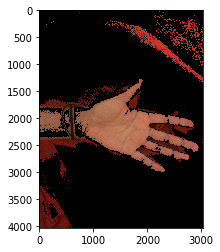

In [185]:
rgb_hand_masked = np.copy(hand)
rgb_hand_masked[rgb_hand_mask != 0] = [0,0,0]

plt.imshow(rgb_hand_masked)

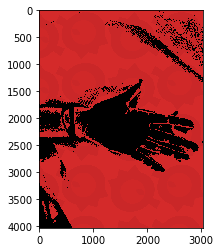

In [186]:
rgb_bg_masked = np.copy(bg_cropped)
rgb_bg_masked[rgb_hand_mask == 0] = [0,0,0]
plt.imshow(rgb_bg_masked)

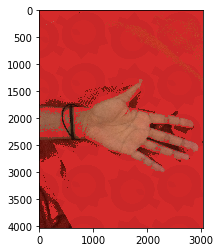

In [187]:
rgb_composite = rgb_hand_masked + rgb_bg_masked
plt.imshow(rgb_composite)